In [153]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from skimage.feature import graycoprops, graycomatrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix

# Preprocessing

In [177]:
def load_images(dir_name):

    img_list = []

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    for item in os.listdir(dir_name):

        img_path = os.path.join(dir_name, item)
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.GaussianBlur(img, (5,5), 1)

        img = clahe.apply(img)
        
        img_list.append(img)

    
    return img_list

def img_to_array(img):
    
    
    img = np.asarray(img)
    return img
  
def find_edges(img_list):

    for i, img in enumerate(img_list):
        
        v = np.median(img)
        sigma = 0.33

        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(max(0, (1.0 + sigma) * v))

        img = cv2.Canny(img, lower, upper)
        
        img_list[i] = img

    
    return img_list

def get_features(image_list):

    feature_list = []

    distances = [1,3,5,9]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2]

    properties = ['energy', 'correlation', 'dissimilarity', 'homogeneity', 'contrast']

    # need to add more distances (1,3,5,9)
    for n, img in enumerate(image_list):
        glcm = graycomatrix(img, distances, angles , levels=256, normed=True)
        feature_row = {}

        for prop in properties:
            prop_values = graycoprops(glcm, prop)   
            for i, dist in enumerate(distances):
                for j, angle in enumerate(angles): 
                    feature_name = f"{prop}_d{dist}_a{int(np.degrees(angle))}"
                    feature_row[feature_name] = prop_values[i, j]

        feature_list.append(feature_row)
    return feature_list

def view_corr(df):
    corr_matrix = df_im.corr()
    sns.heatmap(corr_matrix)
    plt.show()

def pca_df_pick_comp(df):

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)

    pca = PCA()
    pca_features = pca.fit_transform(scaled_features)

    pca_df = pd.DataFrame(pca_features, columns=[f"PC{i+1}" for i in range(pca.n_components_)])

    pca_tot = pca_df
    plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
    plt.xlabel("Num of components")
    plt.ylabel('Cumulative exlpained by variance')
    plt.title('explained variance by pca components')
    plt.show()

    cumulative_var = pca.explained_variance_ratio_.cumsum()
    n_components = 0

    for i, var in enumerate(cumulative_var):
        if var >= 0.95:
            n_components = i + 1
            break

    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(scaled_features)

    pca_columns = [f"PC{i+1}" for i in range(n_components)]
    pca_df= pd.DataFrame(reduced_features, columns=pca_columns)

    return pca_df, pca_tot

    


In [100]:


image_list_1 = load_images("./data_xray/Impacted fracture")
image_list_2 = load_images("./data_xray/Intra-articular fracture")
image_list_3 = load_images("./data_xray/Longitudinal fracture")
image_list_4 = load_images("./data_xray/Oblique fracture")

print(len(image_list_1))
print(len(image_list_2))
print(len(image_list_3))
print(len(image_list_4))



316
130
76
29


<function matplotlib.pyplot.show(close=None, block=None)>

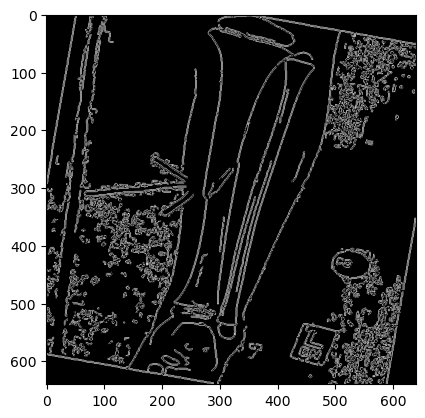

In [104]:
image_list_1 = find_edges(image_list_1)
image_list_2 = find_edges(image_list_2)
image_list_3 = find_edges(image_list_3)
image_list_4 = find_edges(image_list_4)



plt.imshow(image_list_1[0], cmap='gray')
#plt.imshow(img_arr[30])
plt.show

In [160]:
features_1 = get_features(image_list_1)
features_2 = get_features(image_list_2)
features_3 = get_features(image_list_3)
features_4 = get_features(image_list_4)

In [161]:
df_im = pd.DataFrame(features_1)


df_iaf = pd.DataFrame(features_2)


df_lf = pd.DataFrame(features_3)


df_of = pd.DataFrame(features_4)



print(df_im.shape)
print(df_iaf.shape)
print(df_lf.shape)
print(df_of.shape)

(316, 140)
(130, 140)
(76, 140)
(29, 140)


In [178]:
data_df = pd.concat([df_im,df_iaf,df_lf,df_of], axis=0)
print(data_df.shape)

(551, 141)


# Feature Reduction - PCA

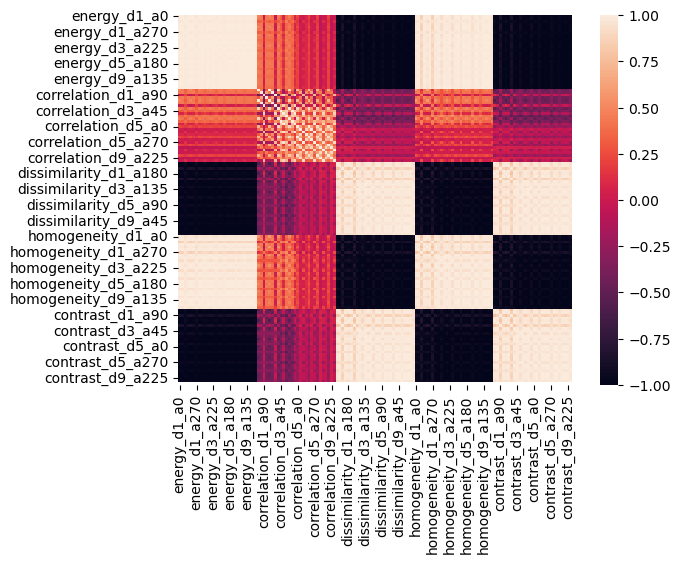

In [179]:
view_corr(data_df)

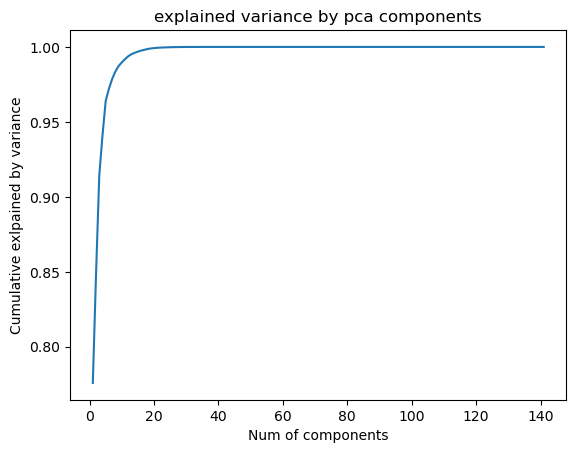

(551, 5)


In [198]:
pca_data, pca_total = pca_df_pick_comp(data_df)
print(pca_data.shape)

In [199]:
df_im = pd.DataFrame(features_1)
df_im['target'] = 0

df_iaf = pd.DataFrame(features_2)
df_iaf['target'] = 1

df_lf = pd.DataFrame(features_3)
df_lf['target'] = 2

df_of = pd.DataFrame(features_4)
df_of['target'] = 3

data_targets = pd.concat([df_im,df_iaf,df_lf,df_of], axis=0)
#target_col = data_targets[: ,-1]
data_targets.head()

,energy_d1_a0,energy_d1_a45,energy_d1_a90,energy_d1_a135,energy_d1_a180,energy_d1_a225,energy_d1_a270,energy_d3_a0,energy_d3_a45,energy_d3_a90,...,contrast_d5_a225,contrast_d5_a270,contrast_d9_a0,contrast_d9_a45,contrast_d9_a90,contrast_d9_a135,contrast_d9_a180,contrast_d9_a225,contrast_d9_a270,target
0,0.864239,0.858349,0.876096,0.861632,0.864239,0.858349,0.876096,0.861244,0.866444,0.866109,...,8710.542564,8025.243418,8750.293681,8873.163356,8352.904368,8857.956841,8750.293681,8873.163356,8352.904368,0
1,0.796074,0.784763,0.811367,0.787252,0.796074,0.784763,0.811367,0.794210,0.801283,0.802965,...,12703.711841,11160.971641,12647.381822,12654.894255,11684.662738,12744.839174,12647.381822,12654.894255,11684.662738,0
2,0.843505,0.836153,0.858484,0.838042,0.843505,0.836153,0.858484,0.841199,0.848058,0.850333,...,9767.510680,8507.650837,9964.520912,9896.853014,9033.522125,9969.003075,9964.520912,9896.853014,9033.522125,0
3,0.948392,0.946393,0.954760,0.947053,0.948392,0.946393,0.954760,0.948015,0.950153,0.949187,...,3290.185008,3137.648253,3075.258704,3366.787161,3102.148499,3354.168989,3075.258704,3366.787161,3102.148499,0
4,0.971235,0.968078,0.973419,0.968019,0.971235,0.968078,0.973419,0.971472,0.971608,0.971549,...,1873.767355,1648.025344,1745.421454,1900.329078,1850.243351,1900.005535,1745.421454,1900.329078,1850.243351,0


In [205]:
col = data_targets['target']
col = np.array(col)
pca_data['target'] = col

# Feature Reduction -

# Classification

In [207]:
X = pca_data.iloc[:, :-1]
Y = pca_data.iloc[:, -1]

In [209]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state=4, test_size= 0.2, shuffle=True)

In [259]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7927927927927928


<Axes: >

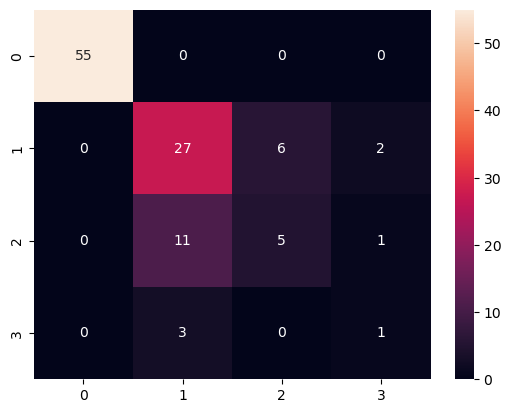

In [260]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')

In [258]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class='multinomial')
log_reg.fit(x_train,y_train)
y_pred = log_reg.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8918918918918919


c:\Users\jacob\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\jacob\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Axes: >

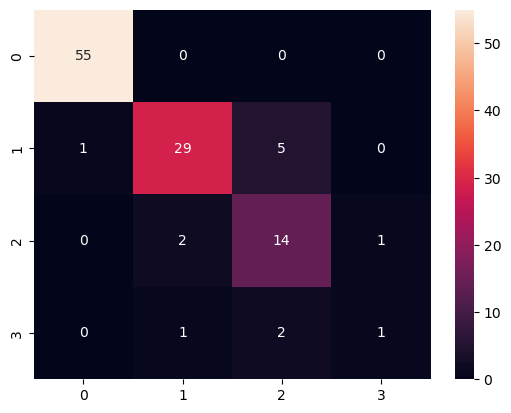

In [217]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')

In [229]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=5)
clf_tree = clf_tree.fit(x_train,y_train)

y_pred = clf_tree.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)



0.8468468468468469


<Axes: >

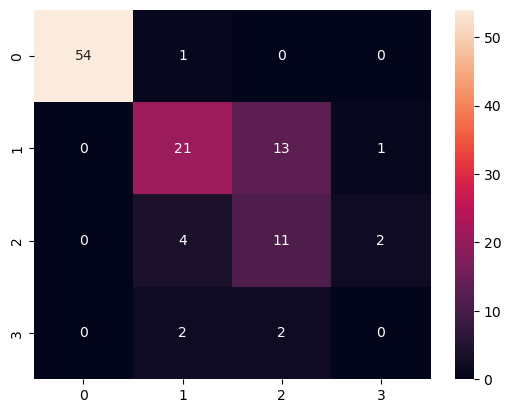

In [223]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')

In [268]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000, random_state=4)

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.8558558558558559


<Axes: >

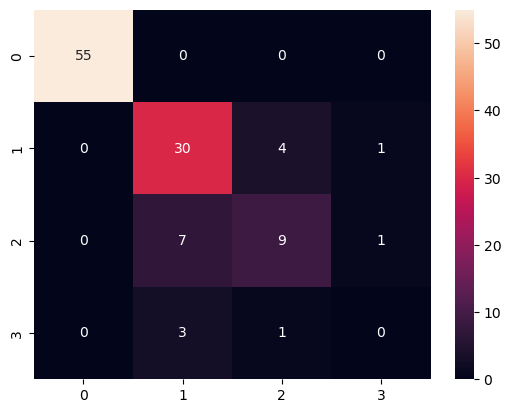

In [236]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')

In [256]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}


clf_svm = svm.SVC(kernel='rbf')

clf_svm.fit(x_train,y_train)
y_pred = clf_svm.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

model = svm.SVC()
gridSearch = GridSearchCV(estimator= model, param_grid=param_grid, refit=True, verbose=3)
gridSearch.fit(x_train, y_train)
print(gridSearch.best_params_)


0.8198198198198198
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.602 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.602 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.602 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.659 total time=   0.0s
[CV 2/5] END .....C=0.1, gam

In [257]:
clf_svm = svm.SVC(kernel='rbf', C=1000, gamma=0.001)

clf_svm.fit(x_train,y_train)
y_pred = clf_svm.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)


0.8828828828828829


# No PCA Test

In [261]:
X = data_targets.iloc[:, :-1]
Y = data_targets.iloc[:, -1]

In [262]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state=4, test_size= 0.2, shuffle=True)

In [264]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.4144144144144144


In [265]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class='multinomial')
log_reg.fit(x_train,y_train)
y_pred = log_reg.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8108108108108109


c:\Users\jacob\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\jacob\anaconda3\envs\cogs118a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [266]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=5)
clf_tree = clf_tree.fit(x_train,y_train)

y_pred = clf_tree.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)


0.7657657657657657


In [267]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=4)

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.8648648648648649


In [270]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}


clf_svm = svm.SVC(kernel='rbf')

clf_svm.fit(x_train,y_train)
y_pred = clf_svm.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

model = svm.SVC()
gridSearch = GridSearchCV(estimator= model, param_grid=param_grid, refit=True, verbose=3)
gridSearch.fit(x_train, y_train)
print(gridSearch.best_params_)


0.5945945945945946
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.602 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.602 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.591 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.602 total time=   0.0s
[CV 2/5] END .....C=0.1, gam

In [271]:
clf_svm = svm.SVC(kernel='rbf', C=0.1, gamma=1)

clf_svm.fit(x_train,y_train)
y_pred = clf_svm.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.4954954954954955


# Test with Resnet

In [ ]:
df_combined = 